In [ ]:
import numpy as np
import napari
import matplotlib.pyplot as plt
from functools import reduce
from statistics import mean
from statistics import stdev
from scipy.ndimage import median_filter

In [ ]:
def PlotLevelsY(data, y, massive):
  fig =  plt.figure(figsize=(15,10))
  plt.imshow(data[:, y, :], cmap = 'afmhot')
  for i in range(4):
      plt.plot(np.arange(0, 512), massive[i, :, y],color='black', linewidth = 2)

In [ ]:
def find_first_in_band(band, len = 5):
  flag = 0
  for i in range(np.shape(band)[0] - len):
    if band[i] + len - 1 == band[i +  len - 1]:
      return band[i]
  if flag == 0:
    return 0

In [ ]:
def find_last_in_band(band, num):
  band = band[::-1]
  flag = 0
  for i in range(np.shape(band)[0] - num - 1):
    if band[i] - (num - 1) == band[i + num - 1]:
      return band[i]
  if flag == 0:
    return 0

In [ ]:
def show_surf(array):
  x = np.arange(array.shape[1])
  y = np.arange(array.shape[0])
  X, Y = np.meshgrid(x, y)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  ax.plot_surface(X, Y, array, cmap='afmhot')
  fig.colorbar(ax.get_children()[0], location='right', shrink = 0.7)
  ax.view_init(10, 45)

  ax.set_xlabel('X, пиксели')
  ax.set_ylabel('Y, пиксели')
  ax.set_zlabel('номер первой точки, пиксели')

  fig.set_size_inches(10, 8)

  plt.show()

In [ ]:
def just_show(picture):
    plt.figure(figsize=(10, 5))
    plt.imshow(picture)
    plt.show()

In [ ]:
def create_mask(upper_layer, second_layer):
    mask = np.zeros((256, 512, 512), dtype=int)
    for x in range(512):
        for y in range(512):
            z1 = upper_layer[x, y]
            z2 = second_layer[x, y]
            mask[int(z1):int(z2), y, x] = 1
    return mask

In [ ]:
def viewer_data(data, masks):
    viewer = napari.view_image(data, name='3D Image', colormap='afmhot', contrast_limits = (15,  41))

    colors = np.linspace(
        start=[1, 1, 1, 1],
        stop=[0, 1, 0, 1],
        num=10,
        endpoint=True
    )
    colors[0] = np.array([1., 1., 1., 0])
    new_colormap = {
      'colors': colors,
      'name': 'white_to_green',
      'interpolation': 'linear'
    }

    for i in range(5):
        viewer.add_image(masks[i], name='Segmentation Mask', colormap=new_colormap, opacity=0.3)
    napari.run()

In [ ]:
def from_dat_to_npy(data_base_folder, folder):
    with open(data_base_folder + '.dat', 'rb') as f:
        raw = np.fromfile(f, np.single)
    Rx = 512  # fast
    Rz = 256  # depth
    Ry = 512  # slow
    data3d_2 = np.zeros((Rz, 2 * Ry, Rx))

    for y in range(2 * Ry):
        for z in range(Rz):
            data3d_2[z, y, :] = raw[z * Rx + y * Rx * Rz:z * Rx + Rx + y * Rx * Rz]

    data3d = np.zeros((Rz, Ry, Rx))

    for y in range(Ry):
        data3d[:, y, :] = np.sqrt(data3d_2[:, 2 * y, :] ** 2 + data3d_2[:, 2 * y + 1, :] ** 2)

    data3d = 10 * np.log10(abs(data3d))
    data3d[np.isinf(data3d)] = 0
    data3d[data3d < 0] = 0

    np.save(folder + '/data.npy', data3d)

In [ ]:
from_dat_to_npy('/home/starman/Downloads/Telegram Desktop/Палец',
                '/home/starman/Desktop/nika/finger0')

/tmp/ipykernel_27776/3593917794.py:21: RuntimeWarning: divide by zero encountered in log10
  data3d = 10 * np.log10(abs(data3d))


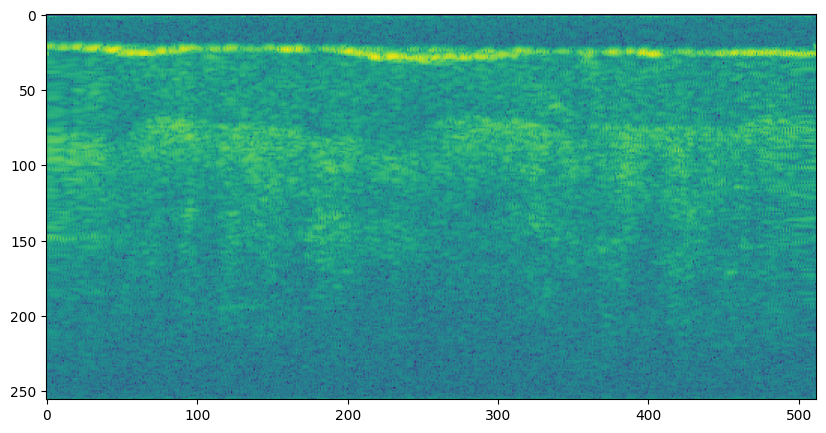

In [ ]:
data = np.load('/home/starman/Desktop/nika/finger0/data.npy')
data[data < 0] = 0
just_show(data[:, 270, :])

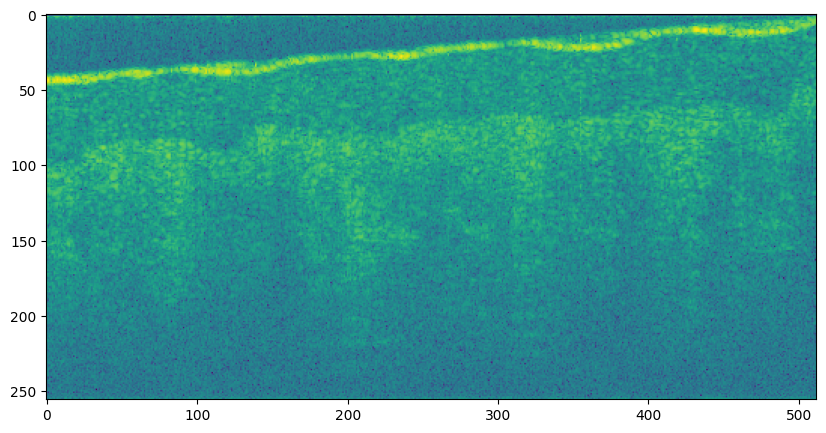

In [ ]:
just_show(data[:, :, 100])

In [ ]:
level = np.zeros(4) #array of values for the levels of noise
levels = np.zeros((4, 512, 512)) #the first point in an A-scan from which the new level starts
masks = np.zeros((5, 256, 512, 512), dtype=int) #masks - layers of skin

In [ ]:
data_shum = data[5:25, 10:100, :]
len = reduce(lambda x, y: x * y, np.shape(data_shum))
data_shum = data_shum.reshape(len)
shum_mean = mean(data_shum)
std_mean = stdev(data_shum)
level[0] = round(shum_mean + std_mean, 4)

for x in range(512):
  for y in range(512):
    band = np.where(data[:, y, x] > level[0])[0]
    levels[0, x, y] = find_first_in_band(band)

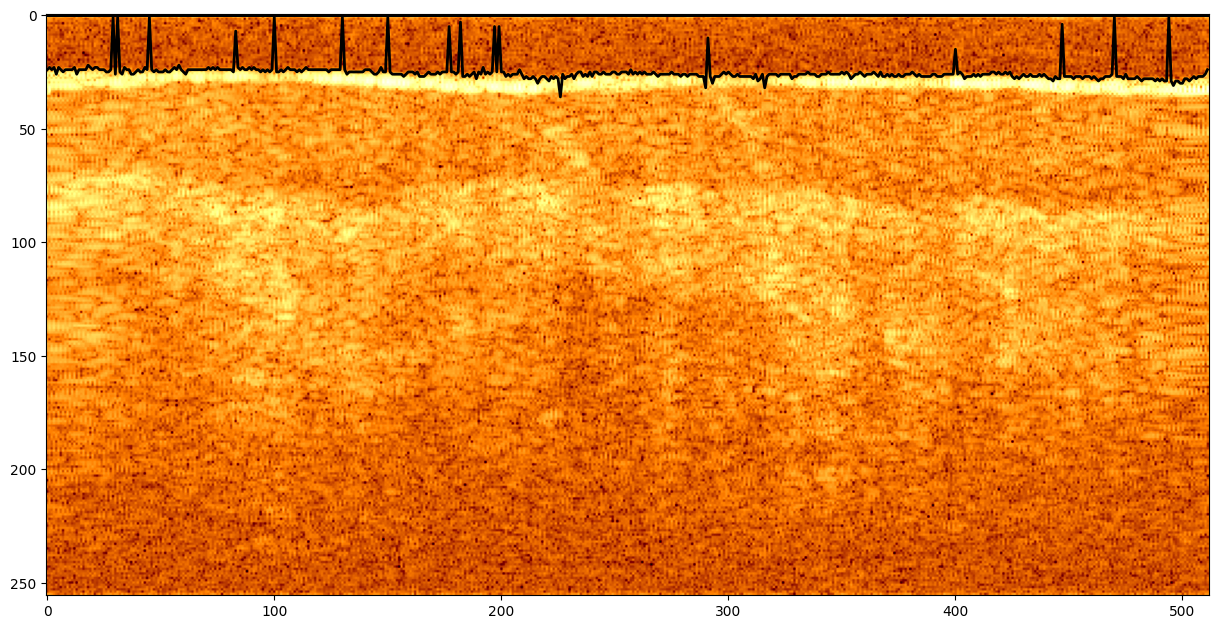

In [ ]:
PlotLevelsY(data, 200, levels)

In [ ]:
zero_level = np.zeros((512, 512))
last_level = np.ones((512, 512)) * 255

In [ ]:
levels[0, :, :] = median_filter(np.asarray(levels[0, :, :], dtype = 'int') , size=11)
masks[0] = create_mask(zero_level, levels[0])
viewer_data(data, masks)

In [ ]:
levels[0, :, :] = median_filter(np.asarray(levels[0, :, :], dtype = 'int') , size=21 ) #try another filter

In [ ]:
masks[0] = create_mask(zero_level, levels[0])
viewer_data(data, masks)

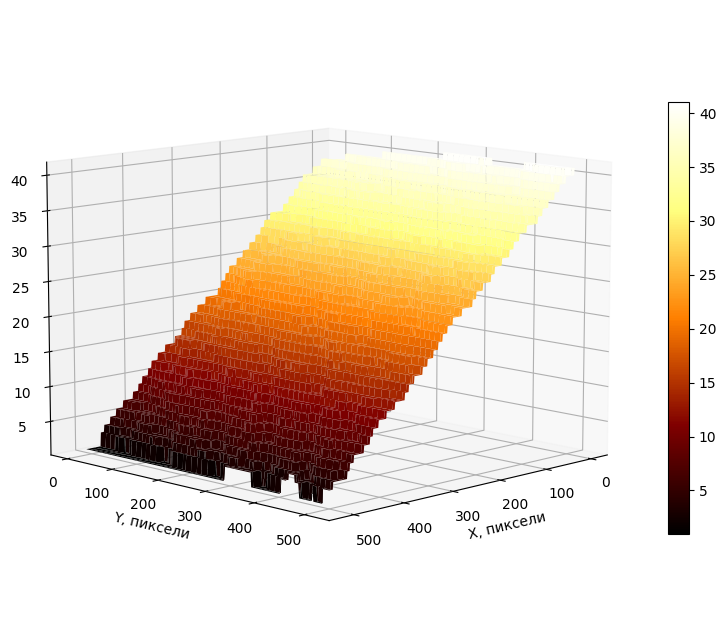

In [ ]:
show_surf(levels[0, :,:])

In [ ]:
new_len_z = np.shape(data)[0] - np.max(levels[0, :, :])
new_data = np.zeros((int(new_len_z) , data.shape[1], data.shape[2]))
for x in range(data.shape[2]):
    for y in range(data.shape[1]):
        start_z = int(levels[0, x, y])
        end_z = int(start_z + new_len_z)
        new_data[:, y, x] = data[start_z:end_z, y, x]

In [ ]:
new_data = median_filter(new_data, size = (1, 18, 18))

In [ ]:
for x in range(512):
  for y in range(512):
    levels[1, x, y] = np.where(new_data[5:, y, x] < 27.9)[0][0] + 5

masks[1] = create_mask(zero_level, np.array(levels[1], dtype = int))
viewer_data(new_data, masks)

In [ ]:
levels[1, :, :] = median_filter(levels[1, :, :], size = 33) #new
masks[1] = create_mask(zero_level, np.array(levels[1], dtype = int))
viewer_data(new_data, masks)

In [ ]:
level[1] = 26 #it doesn't work
for x in range(512):
  for y in range(512):
    band = np.where(new_data[40:, y, x] > level[1])[0]
    levels[2, x, y] = find_first_in_band(band, 2) + 40

levels[2, :, :] = median_filter(levels[2, :, :], size = 33)

masks[2] = create_mask(np.array(levels[1], dtype = int), np.array(levels[2], dtype = int))
viewer_data(new_data, masks)

In [ ]:
from tqdm import tqdm

In [ ]:
#try another filter
level[1] = 26
l0 = 27
l1 = 25.5
l2 = 25

l2 = 24
l3 = 23
l4 = 22
for x in tqdm(range(512)):
  for y in range(512):
    band = np.where(new_data[40:, y, x] > level[1])[0]
    levels[2, x, y] = find_first_in_band(band, 5) + 40
    if levels[2, x, y] == 40:
        band = np.where(new_data[40:, y, x] > l0)[0]
        levels[2, x, y] = find_first_in_band(band, 2) + 40
    if levels[2, x, y] == 40:
        band = np.where(new_data[40:, y, x] > l1)[0]
        levels[2, x, y] = find_first_in_band(band, 2) + 40
    if levels[2, x, y] == 40:
        band = np.where(new_data[40:, y, x] > l2)[0]
        levels[2, x, y] = find_first_in_band(band, 2) + 40
    if levels[2, x, y] == 40:
        band = np.where(new_data[40:, y, x] > l3)[0]
        levels[2, x, y] = find_first_in_band(band, 2) + 40
    if levels[2, x, y] == 40:
        band = np.where(new_data[40:, y, x] > l4)[0]
        levels[2, x, y] = find_first_in_band(band, 2) + 40

levels[2, :, :] = median_filter(levels[2, :, :], size = 21)
levels[2, :, :] = median_filter(levels[2, :, :], size = 33)

masks[2] = create_mask(np.array(levels[1], dtype = int), np.array(levels[2], dtype = int))
viewer_data(new_data, masks)

100%|████████████████████████████████████████| 512/512 [00:02<00:00, 242.20it/s]


In [ ]:
l = 24.7
for x in range(512):
  for y in range(512):
    band = np.where(new_data[int(levels[2, x, y]):125, y, x] > l)[0]
    levels[3, x, y] = find_last_in_band(band, 11) + int(levels[2, x, y])
levels[3, :, :] = median_filter(levels[3, :, :], size = 33)
masks[3] = create_mask(levels[2], levels[3])
viewer_data(new_data, masks)

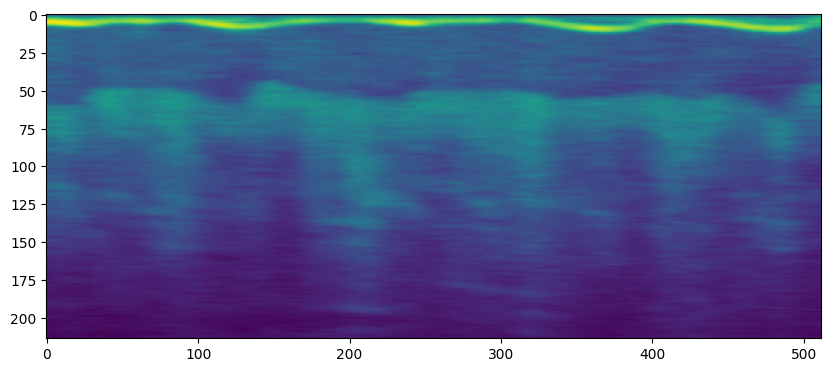

In [ ]:
just_show(new_data[:,:,100])

In [ ]:
l = 25.7
l0 = 25
l1 = 24.5
l2 = 23
for x in range(512):
  for y in range(512):
    band = np.where(new_data[int(levels[2, x, y]):110, y, x] > l)[0]
    levels[3, x, y] = find_last_in_band(band, 9) + int(levels[2, x, y])
    if levels[3, x, y] == int(levels[2, x, y]):
        band = np.where(new_data[int(levels[2, x, y]):110, y, x] > l0)[0]
        levels[3, x, y] = find_last_in_band(band, 6) + int(levels[2, x, y])
    if levels[3, x, y] == int(levels[2, x, y]):
        band = np.where(new_data[int(levels[2, x, y]):110, y, x] > l1)[0]
        levels[3, x, y] = find_last_in_band(band, 9) + int(levels[2, x, y])
    if levels[3, x, y] == int(levels[2, x, y]):
        band = np.where(new_data[int(levels[2, x, y]):110, y, x] > l2)[0]
        levels[3, x, y] = find_last_in_band(band, 9) + int(levels[2, x, y])
levels[3, :, :] = median_filter(levels[3, :, :], size = 33)
masks[3] = create_mask(levels[2], levels[3])
viewer_data(new_data, masks)

In [ ]:
levels[3, :, :] = median_filter(levels[3, :, :], size = 31)
masks[3] = create_mask(levels[2], levels[3])
viewer_data(new_data, masks)

In [ ]:
for i in range(1,4):
    levels[i, :, :] = levels[i, :, :] + levels[0, :, :]

In [ ]:
masks[1] = create_mask(levels[0], levels[1])
masks[2] = create_mask(levels[1], levels[2])
masks[3] = create_mask(levels[2], levels[3])
masks[4] = create_mask(levels[3], last_level)

In [ ]:
viewer_data(data, masks)

In [ ]:
np.save('/home/starman/Desktop/nika/finger0/levels.npy', levels)